# WebRTC

https://webrtc.org/

https://developer.mozilla.org/en-US/docs/Web/API/WebRTC_API

- peer to peer : 중앙 서버를 거치지 않고 클라이언트 컴퓨터끼리 직접 통신하는 방식을 통칭

- 내 영상과 내 오디오와 내 텍스트가 서버로 가지 않음

- 실시간이 속도가 엄청 빠른 이유


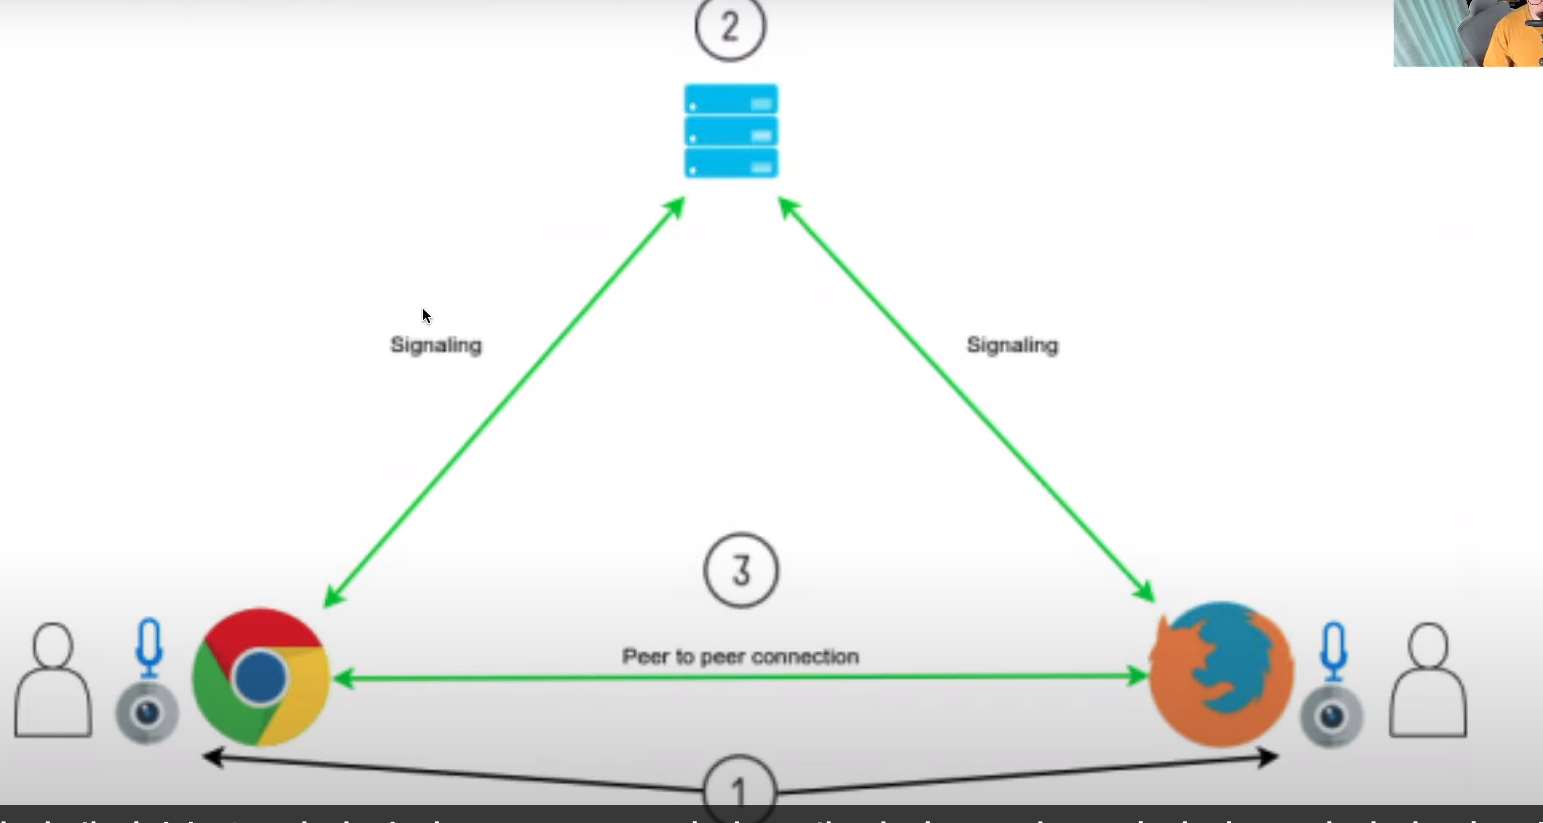

- signaling에 서버가 필요

- 서버는 다른 사람이 어디 있는지 알려주는 역할을 할뿐임

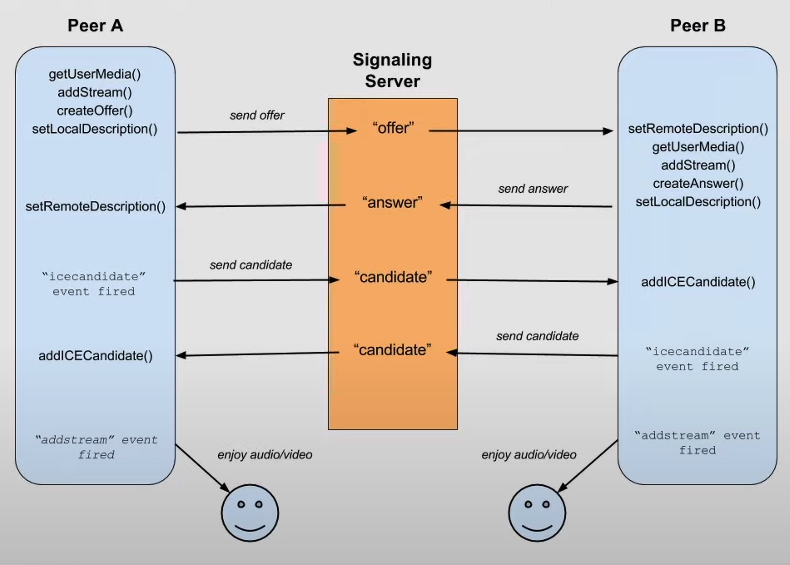

# 01 WebRTC 전 준비
###### app.js
```javascript
const socket = io();

const myFace = document.getElementById("myFace");
const muteBtn = document.getElementById("mute");
const cameraBtn = document.getElementById("camera");
const camerasSelect = document.getElementById("cameras");

const call = document.getElementById("call");

call.hidden = true;

let myStream;
let muted = false;
let cameraOff = false;
let roomName;

// https://developer.mozilla.org/ko/docs/Web/API/MediaDevices/enumerateDevices
async function getCameras() {
  try {
    const devices = await navigator.mediaDevices.enumerateDevices();
    const cameras = devices.filter((device) => {
      return device.kind === "videoinput";
    });
    const currentCamera = myStream.getVideoTracks()[0];

    cameras.forEach((camera) => {
      const option = document.createElement("option");
      option.value = camera.deviceId;
      option.innerText = camera.label;

      if (currentCamera.label === camera.label) {
        option.selected = true;
      }

      camerasSelect.appendChild(option);
    });
    // console.log(cameras);
    // console.log(devices);
  } catch (error) {
    console.log(error);
  }
}

// https://developer.mozilla.org/en-US/docs/Web/API/MediaDevices/getUserMedia
async function getMedia(deviceId) {
  const initialConstrains = {
    audio: true,
    video: { facingMode: "user" },
  };
  const cameraConstraints = {
    audio: true,
    video: { deviceId: { exact: deviceId } },
  };

  try {
    myStream = await navigator.mediaDevices.getUserMedia(
      deviceId ? cameraConstraints : initialConstrains
    );
    myFace.srcObject = myStream;
    //
    if (!deviceId) {
      await getCameras();
    }
  } catch (error) {
    console.log(error);
  }
}

function handleMuteClick() {
  myStream
    .getAudioTracks()
    .forEach((track) => (track.enabled = !track.enabled));
  if (!muted) {
    muteBtn.innerText = "UnMute";
    muted = true;
  } else {
    muteBtn.innerText = "Mute";
    muted = false;
  }
}
function handleCameraClick() {
  myStream
    .getVideoTracks()
    .forEach((track) => (track.enabled = !track.enabled));
  if (cameraOff) {
    cameraBtn.innerText = "Turn Camera Off";
    cameraOff = false;
  } else {
    cameraBtn.innerText = "Turn Camera On";
    cameraOff = true;
  }
}

async function handleCameraChange() {
  await getMedia(camerasSelect.value);
}

muteBtn.addEventListener("click", handleMuteClick);
cameraBtn.addEventListener("click", handleCameraClick);
camerasSelect.addEventListener("input", handleCameraChange);

// Welcome Form
const welcome = document.getElementById("welcome");
const welcomeForm = welcome.querySelector("form");

function startMedia() {
  welcome.hidden = true;
  call.hidden = false;
  getMedia();
}

function handleWelcomeSubmit(event) {
  event.preventDefault();
  const input = welcomeForm.querySelector("input");

  socket.emit("join_room", input.value, startMedia);
  roomName = input.value;
  input.value = "";
}

welcomeForm.addEventListener("submit", handleWelcomeSubmit);


// Socket Code
socket.on("welcome", () => {
  console.log("someone Joined");
});

```

###### home.pug
```pug

doctype html
html(lang="en")
  head
    meta(charset="UTF-8")
    meta(http-equiv="X-UA-Compatible", content="IE=edge")
    meta(name="viewport", content="width=device-width, initial-scale=1.0")
    title Joom
    //- MVP CSS 사용
    link(rel="stylesheet", href="https://unpkg.com/mvp.css@1.12/mvp.css") 
  body 
    header
      h1 Joom 
    main
      div#welcome 
        form
          input(placeholder="room name", required, type="text")
          button Enter room
      div#call
        div#myStream
          video#myFace(autoplay, playsinline, width='400', height='400')
          button#mute Mute
          button#camera Turn Camera Off
          select#cameras 
    script(src="/socket.io/socket.io.js")
    script(src="/public/js/app.js")

```

###### server.js
```javascript
import express from "express";
import http from "http";
import SocketIO from "socket.io";

const app = express();
const port = 3000;

// json file 입출력 설정
app.use(express.json());

// pug 설정
app.set("view engine", "pug");
app.set("views", __dirname + "/views");

// static 작업
app.use("/public", express.static(__dirname + "/public"));

// route 설정
app.get("/", (_, res) => res.render("home"));
app.get("/*", (_, res) => res.redirect("/"));

// http server
const httpServer = http.createServer(app);

// io server
const wsServer = SocketIO(httpServer);

wsServer.on("connection", (socket) => {
  
  socket.on("join_room", (roomName, done) => {
    socket.join(roomName);
    done();
    socket.to(roomName).emit("welcome")
  });


});

httpServer.listen(port, () => {
  console.log(`Joom app listening on http://localhost:${port}`);
});

```